# Group 2: Dekker, Hauser, Tassone, Vogel
## buy/hodl/sell

### Introductory part
e.g. loading packages, reading data, EDA

In [1]:
##### packages
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import math
import matplotlib as 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn import metrics
from sklearn.impute import KNNImputer


In [2]:
##### reading data
#AH
df14 = pd.read_csv(r'C:\Users\Aaron\Documents\Studium UZH\Bachelor\6. Semester\_Machine Learning\project\raw data\2014_Financial_Data.csv')
df15 = pd.read_csv(r'C:\Users\Aaron\Documents\Studium UZH\Bachelor\6. Semester\_Machine Learning\project\raw data\2015_Financial_Data.csv')
df16 = pd.read_csv(r'C:\Users\Aaron\Documents\Studium UZH\Bachelor\6. Semester\_Machine Learning\project\raw data\2016_Financial_Data.csv')
df17 = pd.read_csv(r'C:\Users\Aaron\Documents\Studium UZH\Bachelor\6. Semester\_Machine Learning\project\raw data\2017_Financial_Data.csv')
df18 = pd.read_csv(r'C:\Users\Aaron\Documents\Studium UZH\Bachelor\6. Semester\_Machine Learning\project\raw data\2018_Financial_Data.csv')


df_sp500 = pd.read_csv(r'C:\Users\Aaron\Documents\Studium UZH\Bachelor\6. Semester\_Machine Learning\project\raw data\sp-500-historical-annual-returns.csv')

In [3]:
##### df manipulation
df_sp500 = df_sp500[86:91]

#add column with year
df14['year'] = 2014
df15['year'] = 2015
df16['year'] = 2016
df17['year'] = 2017
df18['year'] = 2018

#add column for recom
df14['recommendation'] = 0
df15['recommendation'] = 0
df16['recommendation'] = 0
df17['recommendation'] = 0
df18['recommendation'] = 0

#rename 'Price Var' col
df14.rename(columns={"2015 PRICE VAR [%]": "PRICE_VAR"},inplace=True)
df15.rename(columns={"2016 PRICE VAR [%]": "PRICE_VAR"},inplace=True)
df16.rename(columns={"2017 PRICE VAR [%]": "PRICE_VAR"},inplace=True)
df17.rename(columns={"2018 PRICE VAR [%]": "PRICE_VAR"},inplace=True)
df18.rename(columns={"2019 PRICE VAR [%]": "PRICE_VAR"},inplace=True)

#dropping name column
df14 = df14.drop(df14.columns[0], axis=1)
df15 = df15.drop(df15.columns[0], axis=1)
df16 = df16.drop(df16.columns[0], axis=1)
df17 = df17.drop(df17.columns[0], axis=1)
df18 = df18.drop(df18.columns[0], axis=1)

In [4]:
##### some minor EDA
df14.columns
df14.info() #we have mostly floats, but also 3 integer variables and 1 object variable (-> see 'One-Hot-Encoding' or 'LabelEncoding')
df14['Class']
df14.describe()
#check which are the integer and object variables
df14.select_dtypes(include = ['integer']) #class, year & recommendation
df14.select_dtypes(include = ['object']) #sector


df15.info()
df16.info()
df17.info()
df18.info()

#dimensions for each data set
year = 14
for el in [df14, df15, df16, df17, df18]:
    print(year, el.shape)
    year += 1

#some boxplots
#plt.boxplot(df14['PRICE_VAR'])

#plt.figure()
#df_bp_log = log(df14['Revenue'])#log scale for better visualization
#df_bp_log['Sector'] = df14['Sector']
#sns.catplot(x="Revenue", y="Sector", kind="box", data=df_bp_log)

Index(['Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense', 'Earnings before Tax',
       ...
       'Asset Growth', 'Book Value per Share Growth', 'Debt Growth',
       'R&D Expense Growth', 'SG&A Expenses Growth', 'Sector', 'PRICE_VAR',
       'Class', 'year', 'recommendation'],
      dtype='object', length=226)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 226 entries, Revenue to recommendation
dtypes: float64(222), int64(3), object(1)
memory usage: 6.6+ MB


0       0
1       0
2       1
3       1
4       1
       ..
3803    1
3804    0
3805    0
3806    1
3807    0
Name: Class, Length: 3808, dtype: int64

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,PRICE_VAR,Class,year,recommendation
count,3.764000e+03,3572.000000,3.734000e+03,3.756000e+03,3.672000e+03,3.749000e+03,3.745000e+03,3.753000e+03,3.745000e+03,3.728000e+03,...,3518.000000,3518.000000,3439.000000,3506.000000,3561.000000,3565.000000,3.808000e+03,3808.000000,3808.0,3808.0
mean,5.879050e+09,12.954244,3.700973e+09,2.188214e+09,9.401830e+07,9.307406e+08,1.438144e+09,6.748248e+08,1.002018e+08,5.725866e+08,...,0.164692,2.279999,0.813931,1.361780,0.596529,0.382284,9.751560e+02,0.429097,2014.0,0.0
std,3.901741e+10,705.605473,3.040688e+10,1.159028e+10,6.408912e+08,4.820928e+09,7.305171e+09,3.786291e+09,6.991091e+08,2.793740e+09,...,2.195115,92.428920,25.630214,18.734301,25.894049,4.696975,4.098461e+04,0.495012,0.0,0.0
min,-6.276160e+08,-1.773200,-5.455740e+08,-1.105000e+09,-1.500000e+05,0.000000e+00,-1.088448e+09,-6.786000e+09,-2.250000e+08,-8.878000e+09,...,-1.000000,-0.979600,-230.000000,-1.051000,-1.043700,-1.000000,-1.003972e+02,0.000000,2014.0,0.0
25%,5.788880e+07,-0.002350,3.135714e+06,3.092900e+07,0.000000e+00,1.548900e+07,3.106600e+07,-1.308000e+06,0.000000e+00,-3.732902e+06,...,0.000000,-0.015400,-0.084550,-0.048200,0.000000,-0.003900,-2.857143e+01,0.000000,2014.0,0.0
50%,4.349010e+08,0.061850,1.414420e+08,1.908760e+08,0.000000e+00,7.381800e+07,1.386610e+08,4.104400e+07,2.563000e+06,2.842700e+07,...,0.000000,0.062200,0.037100,0.000000,0.000000,0.068800,-5.281842e+00,0.000000,2014.0,0.0
75%,2.393625e+09,0.188875,1.199844e+09,8.922534e+08,9.911000e+06,3.510000e+08,5.885100e+08,2.712980e+08,4.300000e+07,2.193835e+08,...,0.063850,0.217100,0.141900,0.210300,0.004700,0.220500,1.331484e+01,1.000000,2014.0,0.0
max,1.824698e+12,42138.663900,1.537249e+12,4.621600e+11,1.153700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,8.720500e+10,...,76.625000,5468.426400,1360.125000,729.576600,1542.611000,225.690000,2.418601e+06,1.000000,2014.0,0.0


,Class,year,recommendation
0,0,2014,0
1,0,2014,0
2,1,2014,0
3,1,2014,0
4,1,2014,0
...,...,...,...
3803,1,2014,0
3804,0,2014,0
3805,0,2014,0
3806,1,2014,0


,Sector
0,Consumer Defensive
1,Consumer Defensive
2,Consumer Defensive
3,Consumer Defensive
4,Consumer Defensive
...,...
3803,Technology
3804,Technology
3805,Technology
3806,Technology


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4120 entries, 0 to 4119
Columns: 226 entries, Revenue to recommendation
dtypes: float64(222), int64(3), object(1)
memory usage: 7.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Columns: 226 entries, Revenue to recommendation
dtypes: float64(222), int64(3), object(1)
memory usage: 8.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Columns: 226 entries, Revenue to recommendation
dtypes: float64(222), int64(3), object(1)
memory usage: 8.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Columns: 226 entries, Revenue to recommendation
dtypes: float64(222), int64(3), object(1)
memory usage: 7.6+ MB
14 (3808, 226)
15 (4120, 226)
16 (4797, 226)
17 (4960, 226)
18 (4392, 226)


### Missing Values/NAs

In [5]:
##### check missing values
df14.isnull().sum().sum()
df15.isnull().sum().sum()
df16.isnull().sum().sum()
df17.isnull().sum().sum()
df18.isnull().sum().sum()
#df_all.isnull().sum().sum()

101103

114348

212549

226269

97298

['operatingCycle', 'cashConversionCycle', 'cashFlowToDebtRatio', 'cashFlowCoverageRatios', 'shortTermCoverageRatios', '10Y Revenue Growth (per Share)', '10Y Operating CF Growth (per Share)', '10Y Net Income Growth (per Share)', '10Y Shareholders Equity Growth (per Share)', 'priceEarningsToGrowthRatio', 'niperEBT', 'effectiveTaxRate', 'nIperEBT', 'dividendPayoutRatio', 'Net Debt to EBITDA', '10Y Dividend per Share Growth (per Share)', 'Total non-current assets', 'Total non-current liabilities', 'Net Debt', 'Other Assets', 'priceCashFlowRatio', 'enterpriseValueMultiple', 'ebtperEBIT', 'returnOnAssets', 'returnOnCapitalEmployed', 'eBTperEBIT', 'freeCashFlowOperatingCashFlowRatio', 'Current ratio', 'ROIC', 'Return on Tangible Assets', 'Working Capital', '5Y Revenue Growth (per Share)', '5Y Operating CF Growth (per Share)', '5Y Net Income Growth (per Share)', '5Y Shareholders Equity Growth (per Share)', '5Y Dividend per Share Growth (per Share)']


36

recommendation                                0.000000
Class                                         0.000000
PRICE_VAR                                     0.000000
year                                          0.000000
Financing Cash Flow                           0.044028
                                                ...   
10Y Revenue Growth (per Share)                0.431762
10Y Shareholders Equity Growth (per Share)    0.438465
shortTermCoverageRatios                       0.486660
operatingCycle                                0.999139
cashConversionCycle                           0.999139
Length: 225, dtype: float64

<Figure size 7200x2160 with 0 Axes>

<BarContainer object of 225 artists>

Text(0, 0.5, 'percentage missing values')

([<matplotlib.axis.XTick at 0x1c9003b10d0>,
 [Text(1, 0, 'Revenue'),
  Text(2, 0, 'Revenue Growth'),
  Text(3, 0, 'Cost of Revenue'),
  Text(4, 0, 'Gross Profit'),
  Text(5, 0, 'R&D Expenses'),
  Text(6, 0, 'SG&A Expense'),
  Text(7, 0, 'Operating Expenses'),
  Text(8, 0, 'Operating Income'),
  Text(9, 0, 'Interest Expense'),
  Text(10, 0, 'Earnings before Tax'),
  Text(11, 0, 'Income Tax Expense'),
  Text(12, 0, 'Net Income - Non-Controlling int'),
  Text(13, 0, 'Net Income - Discontinued ops'),
  Text(14, 0, 'Net Income'),
  Text(15, 0, 'Preferred Dividends'),
  Text(16, 0, 'Net Income Com'),
  Text(17, 0, 'EPS'),
  Text(18, 0, 'EPS Diluted'),
  Text(19, 0, 'Weighted Average Shs Out'),
  Text(20, 0, 'Weighted Average Shs Out (Dil)'),
  Text(21, 0, 'Dividend per Share'),
  Text(22, 0, 'Gross Margin'),
  Text(23, 0, 'EBITDA Margin'),
  Text(24, 0, 'EBIT Margin'),
  Text(25, 0, 'Profit Margin'),
  Text(26, 0, 'Free Cash Flow margin'),
  Text(27, 0, 'EBITDA'),
  Text(28, 0, 'EBIT'),
  Te

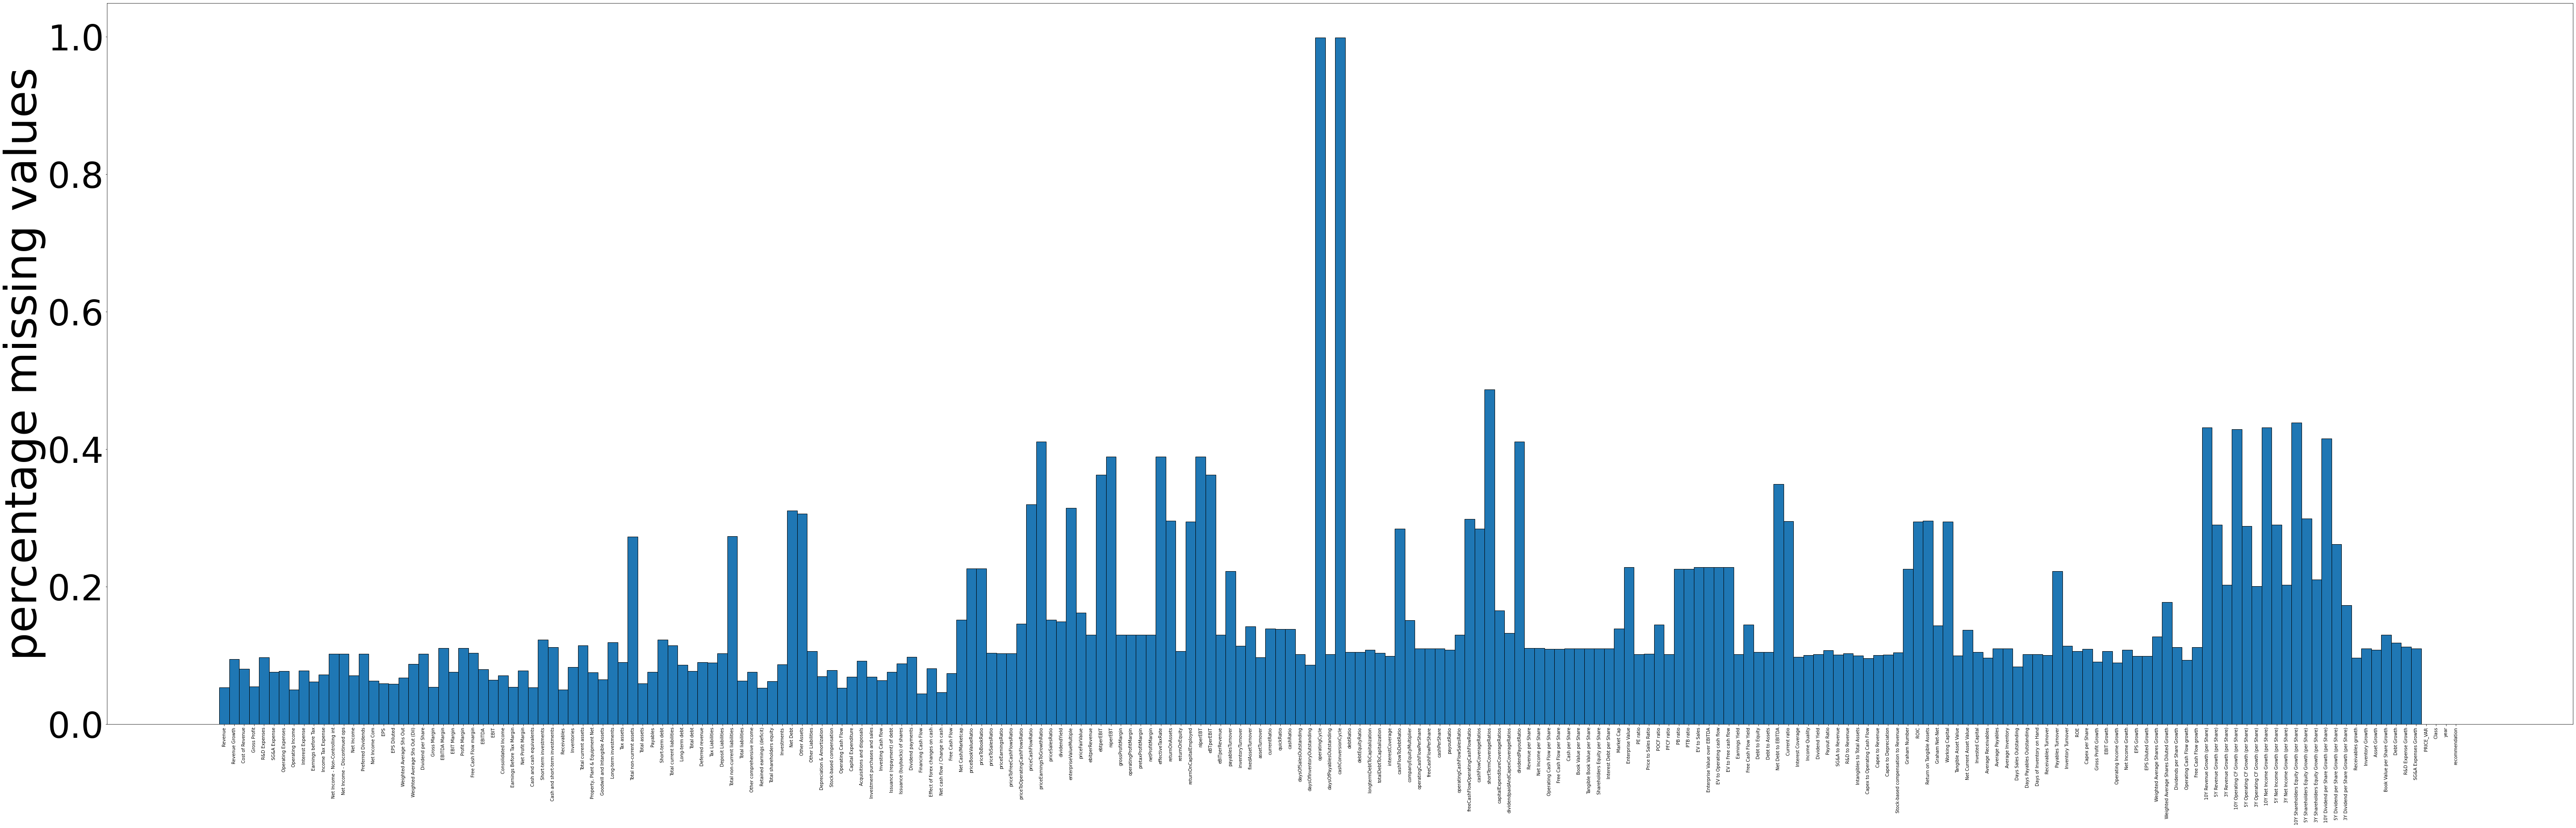

In [130]:
##### further exploration regarding NAs
#function to give back the colnames of cols with more than a certain number (here 1200) of NAs
def name_gettr(data, treshold = 1500):
    res = {}
    for el in data[:1]:
        if data[el].isnull().sum() > treshold:
            res[el] = data[el].isnull().sum()
    return res

#apply function defined above
df14_outl = name_gettr(df14)
df15_outl = name_gettr(df15)
df16_outl = name_gettr(df16)
df17_outl = name_gettr(df17)
df18_outl = name_gettr(df18)


#create a list with dictionaries in order to run another function on them 
df_all_outl = [df14_outl, df15_outl, df16_outl, df17_outl, df18_outl]

#function which creates a list with all unique variables that have more than a certain number of NAs for at least one of the years of interest
def unique_high_NA (data):
    res = []
    for el in data:
        for e in el.keys():
            if not e in res:
                res.append(e)
    return(res)

#apply function and count number of variables to be retired from df
high_NA_vars = unique_high_NA(df_all_outl)
print(high_NA_vars)
len(unique_high_NA(df_all_outl)) #36 (out of 225, i.e. ~16%) variables


#graph showing percentages of values missing (see https://www.kaggle.com/mikevasi/risk-aversion-in-the-stock-market, line 4)
ratio_NA = df_all.isnull().sum()/len(df_all)
pd.Series.sort_values(ratio_NA)
plt.figure(figsize=(100, 30))
plt.bar(np.arange(1,len(ratio_NA)+1), height = ratio_NA, width = 1, ec = 'black')
plt.ylabel('percentage missing values', fontsize = 100)
plt.rc('ytick', labelsize=80)
plt.rc('xtick', labelsize=5)
plt.xticks(np.arange(1,len(ratio_NA)+1), list(df14.columns), rotation = 90)

In [114]:
df14.columns

Index(['Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense', 'Earnings before Tax',
       ...
       'Inventory Growth', 'Asset Growth', 'Book Value per Share Growth',
       'Debt Growth', 'R&D Expense Growth', 'SG&A Expenses Growth',
       'PRICE_VAR', 'Class', 'year', 'recommendation'],
      dtype='object', length=225)

In [7]:
##### implementing a KNN imputation
imputer = KNNImputer(n_neighbors=20, weights='distance', metric='nan_euclidean', copy=True)

## df14
df14_Sector = df14['Sector']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df14.drop(['Sector'], axis = 1, inplace = True)

df14_imputed = imputer.fit_transform(df14)
df14_imputed = pd.DataFrame(df14_imputed)
df14_imputed.columns = list(df14)
df14_imputed.isnull().sum().sum()


# df15
df15_Sector = df15['Sector']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df15.drop(['Sector'], axis = 1, inplace = True)

df15_imputed = imputer.fit_transform(df15)
df15_imputed = pd.DataFrame(df15_imputed)
df15_imputed.columns = list(df15)
df15_imputed.isnull().sum().sum()


# df16
df16_Sector = df16['Sector']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df16.drop(['Sector'], axis = 1, inplace = True)

df16_imputed = imputer.fit_transform(df16)
df16_imputed = pd.DataFrame(df16_imputed)
df16_imputed.columns = list(df16)
df16_imputed.isnull().sum().sum()


# df17
df17_Sector = df17['Sector']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df17.drop(['Sector'], axis = 1, inplace = True)

df17_imputed = imputer.fit_transform(df17)
df17_imputed = pd.DataFrame(df17_imputed)
df17_imputed.columns = list(df17)
df17_imputed.isnull().sum().sum()


# df18
df18_Sector = df18['Sector']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df18.drop(['Sector'], axis = 1, inplace = True)

df18_imputed = imputer.fit_transform(df18)
df18_imputed = pd.DataFrame(df18_imputed)
df18_imputed.columns = list(df18)
df18_imputed.isnull().sum().sum()

0

0

0

0

0

<Figure size 3600x1440 with 0 Axes>

[Text(1395.0, 978.48, 'X[50] <= 92302224.0\ngini = 0.49\nsamples = 3808\nvalue = [2174, 1634]'),
 Text(697.5, 761.0400000000001, 'X[128] <= 2.727\ngini = 0.475\nsamples = 3333\nvalue = [2036, 1297]'),
 Text(348.75, 543.6, 'X[18] <= 7382377.0\ngini = 0.449\nsamples = 2134\nvalue = [1407, 727]'),
 Text(174.375, 326.1600000000001, 'X[40] <= 17948.5\ngini = 0.336\nsamples = 327\nvalue = [257, 70]'),
 Text(87.1875, 108.72000000000003, 'gini = 0.261\nsamples = 227\nvalue = [192, 35]'),
 Text(261.5625, 108.72000000000003, 'gini = 0.455\nsamples = 100\nvalue = [65, 35]'),
 Text(523.125, 326.1600000000001, 'X[81] <= 7.74\ngini = 0.463\nsamples = 1807\nvalue = [1150, 657]'),
 Text(435.9375, 108.72000000000003, 'gini = 0.382\nsamples = 494\nvalue = [367, 127]'),
 Text(610.3125, 108.72000000000003, 'gini = 0.481\nsamples = 1313\nvalue = [783, 530]'),
 Text(1046.25, 543.6, 'X[48] <= 445779008.0\ngini = 0.499\nsamples = 1199\nvalue = [629, 570]'),
 Text(871.875, 326.1600000000001, 'X[204] <= 0.003\n

|--- Deposit Liabilities <= 92302224.00
|   |--- capitalExpenditureCoverageRatios <= 2.73
|   |   |--- Weighted Average Shs Out <= 7382377.00
|   |   |   |--- Tax assets <= 17948.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- Tax assets >  17948.50
|   |   |   |   |--- class: 0.0
|   |   |--- Weighted Average Shs Out >  7382377.00
|   |   |   |--- priceCashFlowRatio <= 7.74
|   |   |   |   |--- class: 0.0
|   |   |   |--- priceCashFlowRatio >  7.74
|   |   |   |   |--- class: 0.0
|   |--- capitalExpenditureCoverageRatios >  2.73
|   |   |--- Deferred revenue <= 445779008.00
|   |   |   |--- 3Y Operating CF Growth (per Share) <= 0.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- 3Y Operating CF Growth (per Share) >  0.00
|   |   |   |   |--- class: 1.0
|   |   |--- Deferred revenue >  445779008.00
|   |   |   |--- Capital Expenditure <= -205000000.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- Capital Expenditure >  -205000000.00
|   |   |   |   |--- class: 1.0
|--- Deposit

array([ 50, 128,  18,  40,  81,  48, 204,  63,   3,  59,  12,  61, 141,
        78, 137], dtype=int64)

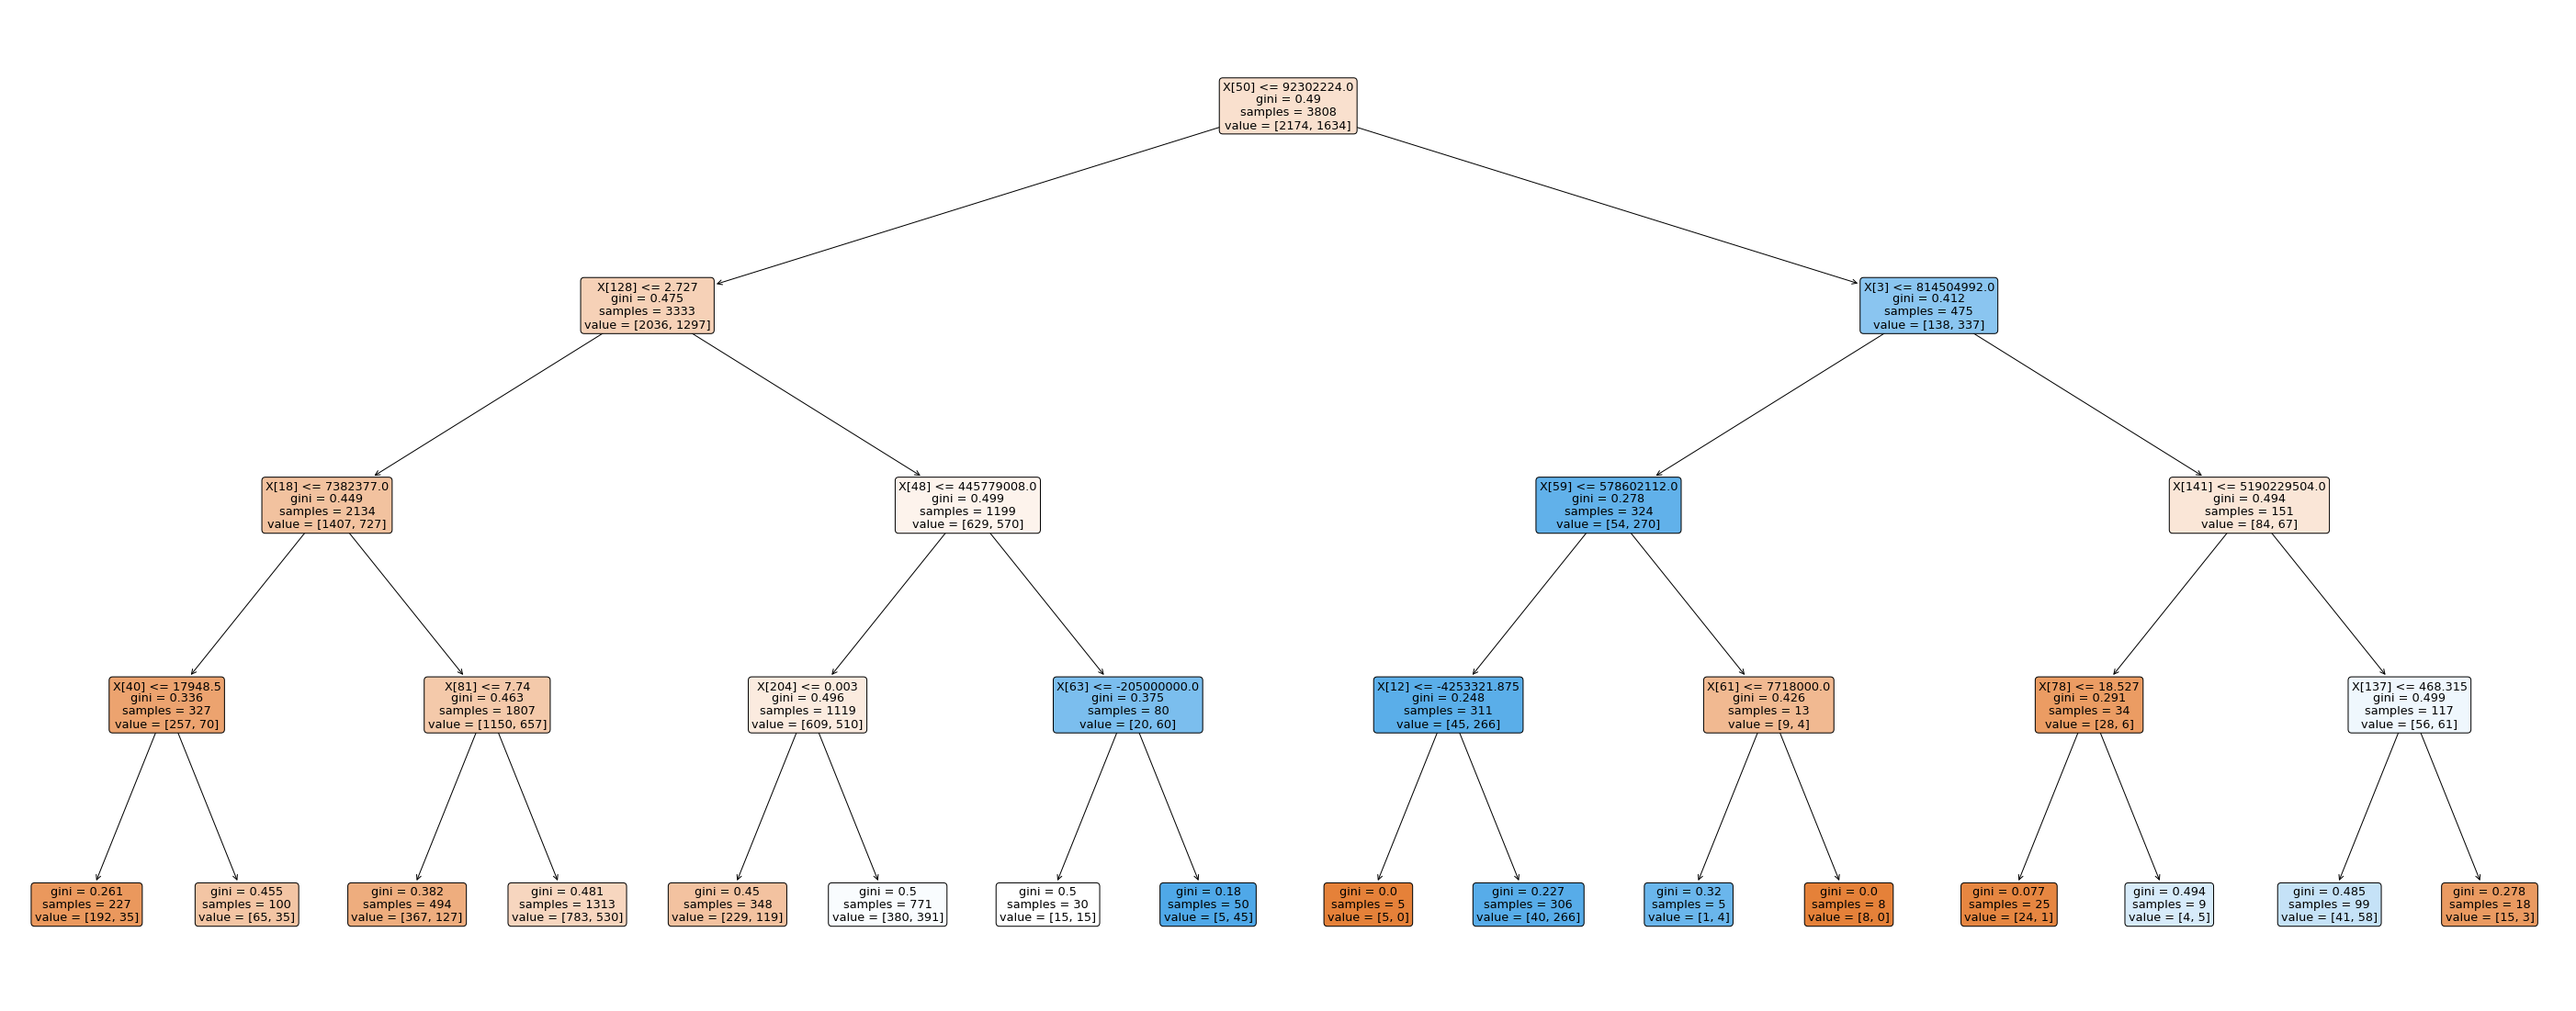

In [9]:
##### naive classification tree in order to see whether one of the variables ommitted is able to explain the dependent variable
Y = df14_imputed['Class']
X = df14_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4)
tree_fit_df14 = tree.fit(X, Y)
plt.figure(figsize = (50, 20))
plot_tree(tree_fit_df14, filled = True, rounded = True)

#tree in text form
tree_text_df14 = export_text(tree_fit_df14, feature_names=list(X))
print(tree_text_df14)

#extract splitting features
tree_features_df14 = tree_fit_df14.tree_.feature
tree_features_df14 = tree_features_df14[tree_features_df14 != -2]
tree_features_df14


In [17]:
##### interpretation of the results from the desicion tree
#for df14:

#function to get the column names of the variables which were used to fit the decision tree
def imp_feat(data, idx): #imp_feat: important features
    res = []
    for el in idx:
        res.append(data.columns[el])
    return(res)

#apply above function to the data set
imp_feat_list_df14 = imp_feat(data = df14_imputed, idx = tree_features_df14)

misfits_df14 = []
for el in imp_feat_list_df14:
    if el in high_NA_vars:
        misfits_df14.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df14[misfits_df14].isna().sum() #we see that apparently the three variables in the list 'misfits' do NOT have more than the treshold value of NAs for the year 2014 (but for some other year)

features with high NA values (in at least one year) that are important according to the classification tree:


priceCashFlowRatio    1053
dtype: int64

In [14]:
#####for 15-18

#df15
Y = df15_imputed['Class']
X = df15_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df15 = tree.fit(X, Y)

#extract splitting features
tree_features_df15 = tree_fit_df15.tree_.feature
tree_features_df15 = tree_features_df15[tree_features_df15 != -2]
tree_features_df15

#apply function to get col names
imp_feat_list_df15 = imp_feat(data = df15_imputed, idx = tree_features_df15)

misfits_df15 = []
for el in imp_feat_list_df15:
    if el in high_NA_vars:
        misfits_df15.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df15[misfits_df15].isna().sum()


####################################################################################################
#df16
Y = df16_imputed['Class']
X = df16_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df16 = tree.fit(X, Y)

#extract splitting features
tree_features_df16 = tree_fit_df16.tree_.feature
tree_features_df16 = tree_features_df16[tree_features_df16 != -2]
tree_features_df16

#apply function to get col names
imp_feat_list_df16 = imp_feat(data = df16_imputed, idx = tree_features_df16)

misfits_df16 = []
for el in imp_feat_list_df16:
    if el in high_NA_vars:
        misfits_df16.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df16[misfits_df16].isna().sum()


####################################################################################################
#df17
Y = df17_imputed['Class']
X = df17_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df17 = tree.fit(X, Y)

#extract splitting features
tree_features_df17 = tree_fit_df17.tree_.feature
tree_features_df17 = tree_features_df17[tree_features_df17 != -2]
tree_features_df17

#apply function to get col names
imp_feat_list_df17 = imp_feat(data = df17_imputed, idx = tree_features_df17)

misfits_df17 = []
for el in imp_feat_list_df17:
    if el in high_NA_vars:
        misfits_df17.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df17[misfits_df17].isna().sum()


####################################################################################################
#df18
Y = df18_imputed['Class']
X = df18_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df18 = tree.fit(X, Y)

#extract splitting features
tree_features_df18 = tree_fit_df18.tree_.feature
tree_features_df18 = tree_features_df18[tree_features_df18 != -2]
tree_features_df18

#apply function to get col names
imp_feat_list_df18 = imp_feat(data = df18_imputed, idx = tree_features_df18)

misfits_df18 = []
for el in imp_feat_list_df18:
    if el in high_NA_vars:
        misfits_df18.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df18[misfits_df18].isna().sum()

array([ 22, 133,  69, 185,  96,  86,  65,  81, 160,  68, 127, 181, 104,
        30,  90], dtype=int64)

priceCashFlowRatio
shortTermCoverageRatios


priceCashFlowRatio         1197
shortTermCoverageRatios    1925
dtype: int64

array([  7,  87, 139,  31, 170, 140,  17, 113,  39,  15, 164, 107, 206,
       216,  20], dtype=int64)

ROIC
5Y Net Income Growth (per Share)


ROIC                                1602
5Y Net Income Growth (per Share)    1680
dtype: int64

array([ 86, 110,  44, 182,  12,  20,  23,  80, 151,  85,   3, 163, 204,
       215], dtype=int64)

operatingCycle
enterpriseValueMultiple


operatingCycle             4955
enterpriseValueMultiple    1800
dtype: int64

array([174, 195, 143,  61,  38,  16,  68, 208,  81,  65,  16, 210,  24,
         8,  41], dtype=int64)

10Y Shareholders Equity Growth (per Share)
priceCashFlowRatio
Total non-current assets


10Y Shareholders Equity Growth (per Share)    1695
priceCashFlowRatio                            1256
Total non-current assets                      1041
dtype: int64

In [15]:
#for all the data

#create a list with all raw data
df_all = pd.concat([df14, df15, df16, df17, df18], ignore_index=True)

#create a list with all imputed data 
df_all_imputed = pd.concat([df14_imputed, df15_imputed, df16_imputed, df17_imputed, df18_imputed], ignore_index = True)


Y = df_all_imputed['Class']
X = df_all_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_all = tree.fit(X, Y)
plt.figure(figsize = (50, 20))
#plot_tree(tree_fit_all, filled = True, rounded = True)

#tree in text form
tree_text_all = export_text(tree_fit_all, feature_names=list(X))
#print(tree_text_all)

#extract splitting features
tree_features_all = tree_fit_all.tree_.feature
tree_features_all = tree_features_all[tree_features_all != -2]
tree_features_all


#apply function to get col names
imp_feat_list_all = imp_feat(data = df_all_imputed, idx = tree_features_all)

misfits = []
for el in imp_feat_list_all:
    if el in high_NA_vars:
        misfits.append(el)

        df_all[misfits].isna().sum() #we see that apparently the three variables in the list 'misfits' do NOT have more than the treshold value of NAs for the year 2014 (but for some other year)

<Figure size 3600x1440 with 0 Axes>

array([110,  23, 100,  18, 140,  20,  41,  84, 221, 112, 110,  50,  92,
        42, 137], dtype=int64)

operatingCycle
Total non-current assets
cashConversionCycle
operatingCycle


operatingCycle              22058
Total non-current assets     6022
cashConversionCycle         22058
operatingCycle              22058
dtype: int64

<Figure size 3600x1440 with 0 Axes>

In [47]:
#consolidate all variables which are important for any of the five years
misfits_all = list(set(misfits_df14 + misfits_df15 + misfits_df16 + misfits_df17 + misfits_df18)) #set in order to remove dublicates
misfits_all

df_temporary = [df14, df15, df16, df17, df18]
for el in df_temporary:
    print(el[misfits_all].isnull().sum(), "\n")

#from this output we conclude that:
    #even if operatingCycle would be able to predict future return, we have way too many NAs
    #also shortTermCoverageRatios and 10y Shareholder Equity Growth has too few values over all years, hence we remove it from the data set
    #we leave in the dataset the following:
        #priceCashFlowRatio
        #5Y Net Income Growth (per Share)
        #enterpriseValueMultiple
        #ROIC
        #Total non-current assets

['priceCashFlowRatio',
 'operatingCycle',
 '5Y Net Income Growth (per Share)',
 'enterpriseValueMultiple',
 'ROIC',
 'Total non-current assets',
 '10Y Shareholders Equity Growth (per Share)',
 'shortTermCoverageRatios']

priceCashFlowRatio                            1053
operatingCycle                                3807
5Y Net Income Growth (per Share)              1037
enterpriseValueMultiple                        944
ROIC                                           987
Total non-current assets                       908
10Y Shareholders Equity Growth (per Share)    1585
shortTermCoverageRatios                       1956
dtype: int64 

priceCashFlowRatio                            1197
operatingCycle                                4118
5Y Net Income Growth (per Share)              1214
enterpriseValueMultiple                       1224
ROIC                                          1125
Total non-current assets                      1029
10Y Shareholders Equity Growth (per Share)    1766
shortTermCoverageRatios                       1925
dtype: int64 

priceCashFlowRatio                            1708
operatingCycle                                4792
5Y Net Income Growth (per Share)              1680
e

In [69]:
##### dropping variables with too many NAs

#high_NA_vars #uncomment to see variables that have too many NAs
#we now drop those variables with exception of the following five variables:
    #priceCashFlowRatio
    #5Y Net Income Growth (per Share)
    #enterpriseValueMultiple
    #ROIC
    #Total non-current assets

notdrop = ['priceCashFlowRatio', '5Y Net Income Growth (per Share)', 'enterpriseValueMultiple', 'ROIC', 'Total non-current assets']
drop = [x for x in high_NA_vars if x not in notdrop]

df14_imputed.drop(drop, axis = 1, inplace = True)
df15_imputed.drop(drop, axis = 1, inplace = True)
df16_imputed.drop(drop, axis = 1, inplace = True)
df17_imputed.drop(drop, axis = 1, inplace = True)
df18_imputed.drop(drop, axis = 1, inplace = True)
df_all_imputed.drop(drop, axis = 1, inplace = True)

KeyError: "['operatingCycle' 'cashConversionCycle' 'cashFlowToDebtRatio'\n 'cashFlowCoverageRatios' 'shortTermCoverageRatios'\n '10Y Revenue Growth (per Share)' '10Y Operating CF Growth (per Share)'\n '10Y Net Income Growth (per Share)'\n '10Y Shareholders Equity Growth (per Share)' 'priceEarningsToGrowthRatio'\n 'niperEBT' 'effectiveTaxRate' 'nIperEBT' 'dividendPayoutRatio'\n 'Net Debt to EBITDA' '10Y Dividend per Share Growth (per Share)'\n 'Total non-current liabilities' 'Net Debt' 'Other Assets' 'ebtperEBIT'\n 'returnOnAssets' 'returnOnCapitalEmployed' 'eBTperEBIT'\n 'freeCashFlowOperatingCashFlowRatio' 'Current ratio'\n 'Return on Tangible Assets' 'Working Capital'\n '5Y Revenue Growth (per Share)' '5Y Operating CF Growth (per Share)'\n '5Y Shareholders Equity Growth (per Share)'\n '5Y Dividend per Share Growth (per Share)'] not found in axis"

### Zero values
when going though the data one think that came to attention was the many zeroes \
the question is how to handle those zeroes as some make more sense (e.g. 0 R&D Expenses for a gold mining company) while others are more ambiguous (e.g. revenue of 0, very few firms have negative revenues for the year 2014)

In [ ]:
##### inspection of 0-values

df14_zero_vals = df14.isin([0]).sum()
#df14_zero_vals

df15_zero_vals = df15.isin([0]).sum()
#df15_zero_vals

df16_zero_vals = df16.isin([0]).sum()
#df16_zero_vals

df17_zero_vals = df17.isin([0]).sum()
#df17_zero_vals

df18_zero_vals = df18.isin([0]).sum()
#df18_zero_vals


#seq = np.arange(df14.shape[1])
#y = df14_zero_vals.values.tolist()
#plt.figure(figsize=(50,10))
#plt.subplot(2,1,2)
#plt.bar(seq, y)
#plt.ylabel('number of 0-values', fontsize = 50)
#plt.xticks(seq, df14_zero_vals.index.values, rotation = 'vertical')
#plt.show()

## collection of thougts
### Imputing

possible ways of imputing:
* dropna() -> not very elaborate, dropping all NAs would result in a major data waste
* fillna() -> very simplistic method, probably not appropriate
* imputing with mean values -> [...] [T]he correlation structure of a dataset may not be captured if the decision is to plug missing values with zeros or with mean value over the samples. (Imputation of Missing Values in Economic and Financial Time Series Data Using Five Principal Component Analysis (PCA) Approaches, 2019, s. 52)
* imputing with median values
* imputing with most frequent value
* imputing with mean/median/most frequent value of each of the sectors (assuming macro-trends and macro-factors within each sector)
* KNN imputation
* iterative imputer (scikit-learn)


possible papers:
* A review on missing value estimation using imputation algorithm, Journal of Physics ConferenceSeries
* Gautrain, C., & Ravi, V. (2015). Data imputation via evolutionary computation,clustering and a neural network. Neurocomputing, 156:134-142
* Ping, X. O., Lai F., Tseng Y.J, Liang J. D., Huang G. T., Yang, P.M. (2014).Evaluation of imputation methods for missing data and their eﬀect on thereliability of predictive models. International Conference on Bioinformatics,Biocomputational Systems and Biotechnologies, 6, 8-14.
* Schmitt, P; Mandel, J; & Guedj, M. (2015). A comparison of six methods formissing data imputation. Journal of Biometrics & Biostatistics, 6(224), 1-6.
* Imputation of Missing Values in Economic and Financial Time Series Data Using Five Principal Component Analysis (PCA) Approaches, August 2019, Central Bank of Ntigeria Journal of Applied Statistics, DOI: 10.33429/Cjas.10119.3/6
* IMPUTATION OF MISSING VALUES IN THE FUNDAMENTAL DATA: UNLEASHING MICE FRAMEWORK

approach:
* multiple imputation (i.e. apply several imputation methods and analyse how the different methods affects performance of the algorithm)

### Zero values
* treat as NAs or simply as "zeroes"?
* maybe mixed? depending on 

### Topics to consider
* imputing
    * (e.g. KNN, https://www.kaggle.com/priyankasachdeva20/catboost-model-to-classify-buy-or-sell-stocks/comments line 11)
    * https://scikit-learn.org/stable/modules/impute.html
    * perhaps different methods for different variables
* 0s in df
* outliers
    * Z score
    * IQR



* selection of relevant ratios/fundamental data
    * remove variables which are heavily correlated to each other (see line 7 in https://www.kaggle.com/mikevasi/risk-aversion-in-the-stock-market)
* feature engineering 
    * https://www.nber.org/system/files/working_papers/w25398/w25398.pdf (Dacheng, Empirical Asset Pricing via ML)
    * momentum?
    * categorical variable for market cap
* class imbalance
    * use the stratify option available within sklearn.model_selection.train_test_split
* analysis